In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import random_split, DataLoader,Dataset,SubsetRandomSampler
import torchvision.transforms as transform
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Look into the data directory
data_dir = '../input/fruits/fruits-360'
TRAIN_DIR = data_dir + '/Training'                           # Contains training images
TEST_DIR = data_dir + '/Test' 

In [4]:
# Data transforms

train_tfms = transform.Compose([ transform.RandomCrop(80, padding=6, padding_mode='reflect'),transform.RandomHorizontalFlip(p=0.30),
                transform.RandomRotation(20), transform.ToTensor(), transform.RandomErasing(p=0.3, inplace=True)])
valid_tfms = transform.Compose([transform.Resize(80),transform.ToTensor()])
                         

In [5]:
# PyTorch datasets
train_ds = ImageFolder(TRAIN_DIR,train_tfms)
val_ds = ImageFolder(TRAIN_DIR,valid_tfms)
test_ds = ImageFolder(TEST_DIR,valid_tfms)

In [6]:
print(len(train_ds),len(test_ds))

67692 22688


***Lets print each classes and number of images in it***

In [10]:
image_count = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(TRAIN_DIR):
    folder_num = len(os.listdir(os.path.join(TRAIN_DIR,folder)))
    image_count.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
print('-' * 24)    
print("Number of classes : ",len(class_names))

class             Count:
------------------------
Grapefruit Pink      490
Apple Crimson Snow   444
Potato Red Washed    453
Pineapple            490
Cherry Wax Red       492
Fig                  702
Peach Flat           492
Raspberry            490
Maracuja             490
Plum 2               420
Cactus fruit         490
Cherry 2             738
Mandarine            490
Grape White          490
Corn Husk            462
Grape Blue           984
Quince               490
Cucumber Ripe        392
Pear Kaiser          300
Cherry Wax Yellow    492
Avocado ripe         491
Grape White 2        490
Grapefruit White     492
Watermelon           475
Pepino               490
Onion Red Peeled     445
Apple Red Delicious  490
Salak                490
Mango Red            426
Apple Pink Lady      456
Physalis with Husk   492
Pineapple Mini       493
Pear Red             666
Nectarine Flat       480
Onion Red            450
Tamarillo            490
Peach                492
Tomato Yellow        459


***We can also visualize the same***

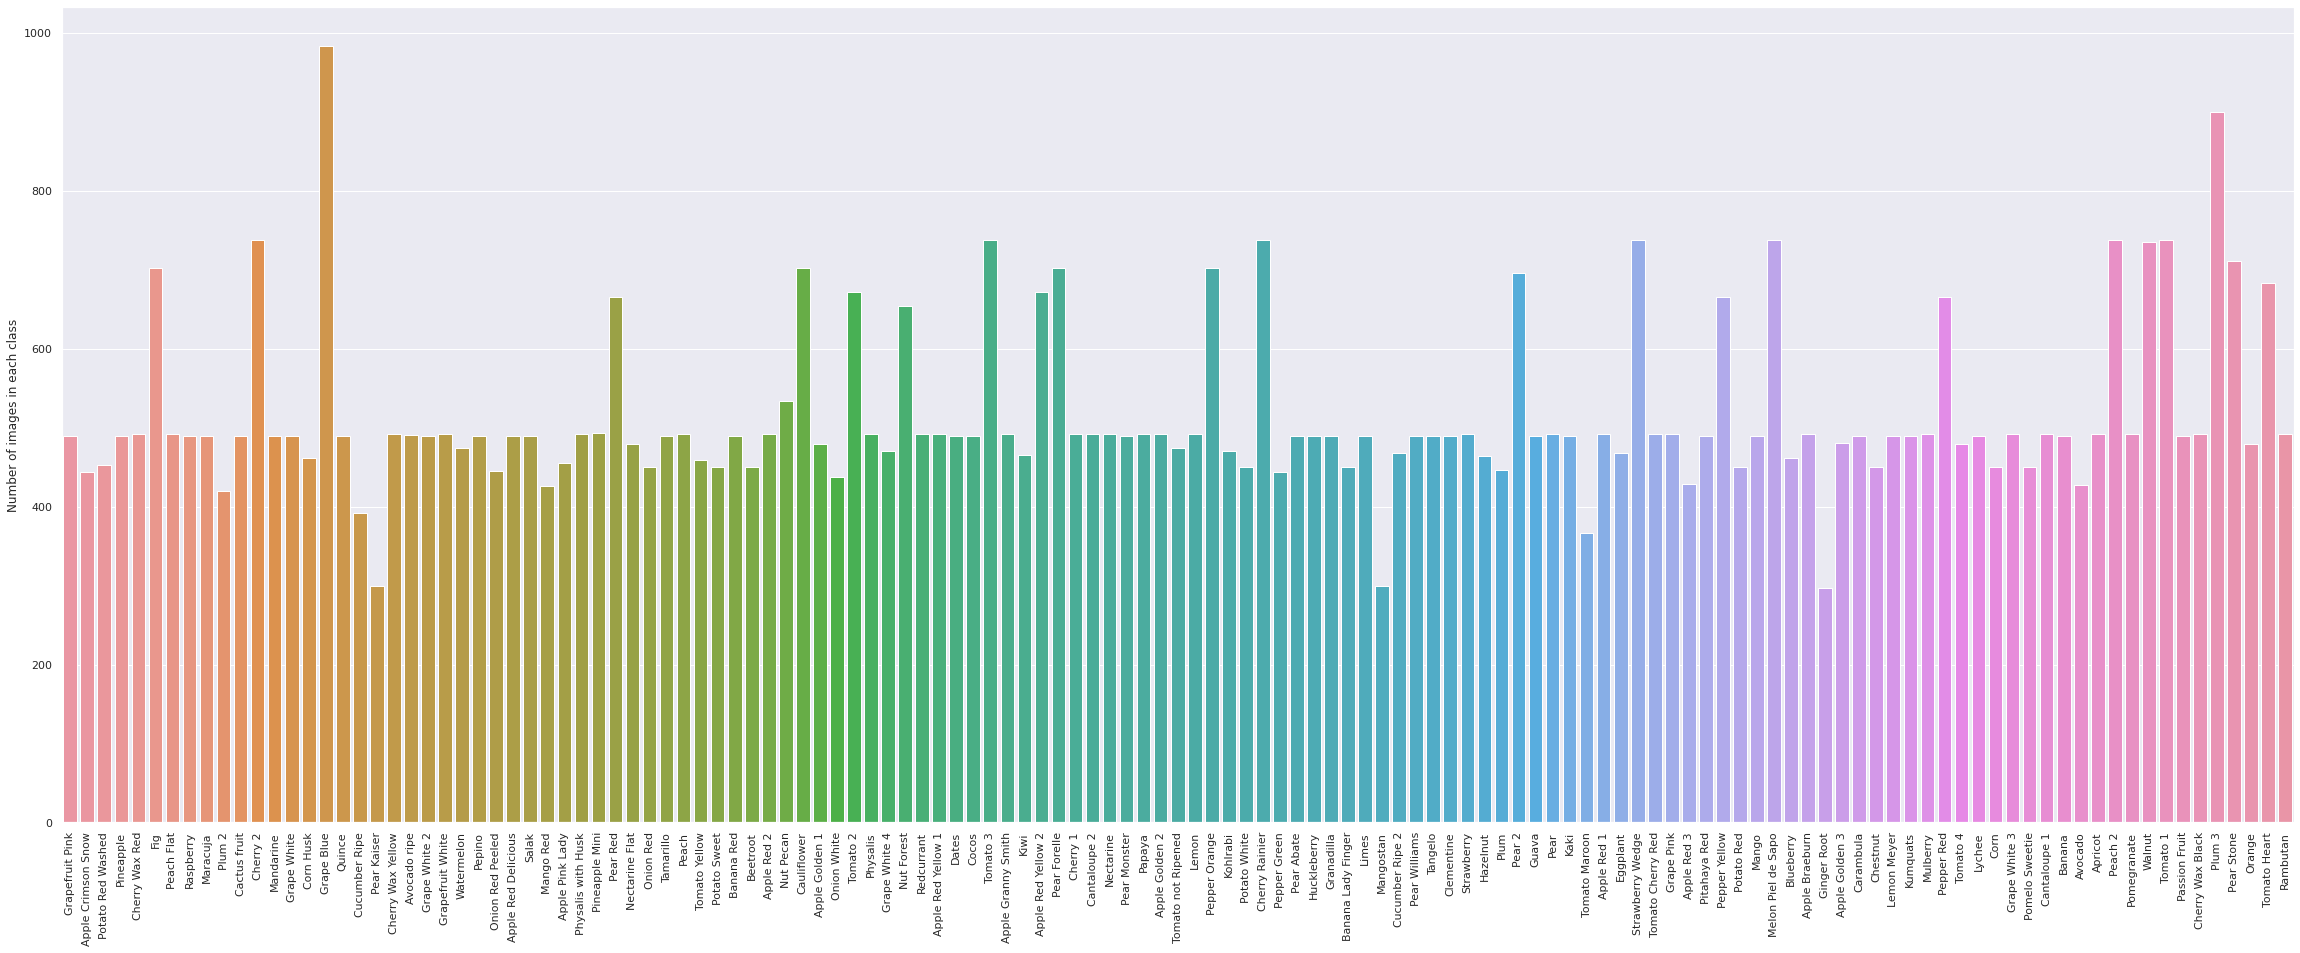

In [65]:

sns.set(rc={'figure.figsize':(40,15)})
sns.barplot(x=class_names, y=image_count)
plt.ylabel('Number of images in each class')
plt.xticks(rotation=90)
plt.show()

In [12]:
valid_size = 0.25
num_train = len(train_ds)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print(len(train_idx),len(valid_idx))

50769 16923


In [13]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [14]:
random_seed = 20
torch.manual_seed(random_seed);

In [15]:
batch_size = 64

In [16]:
train_dl = DataLoader(
        train_ds, batch_size=batch_size, sampler=train_sampler,
        num_workers=4, pin_memory=True)
val_dl = DataLoader(
        val_ds, batch_size=batch_size, sampler=valid_sampler,
        num_workers=4, pin_memory=True)

In [ ]:
'''
mean = 0.
std = 0.
nb_samples = 0.
for imgs, _ in train_dl:
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print(mean,std)'''

In [17]:
image, label = train_ds[0]
print(image.shape, label)

torch.Size([3, 80, 80]) 0


In [67]:
def show_example(img, label):
    sns.set(rc={'figure.figsize':(4,4)})
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.rcParams["axes.grid"] = False
    plt.imshow(img.permute(1, 2, 0))

Label:  Apple Braeburn (0)


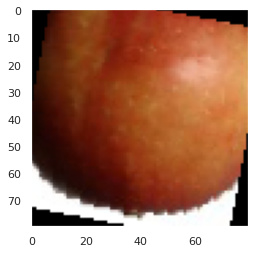

In [70]:
show_example(*train_ds[187])

Label:  Cherry 1 (26)


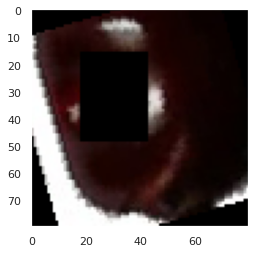

In [69]:
show_example(*train_ds[13116])

In [26]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

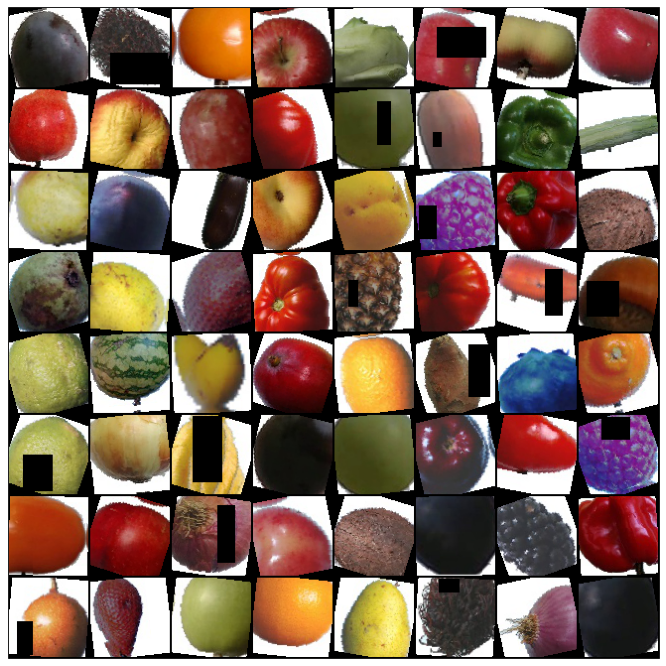

In [27]:
show_batch(train_dl)

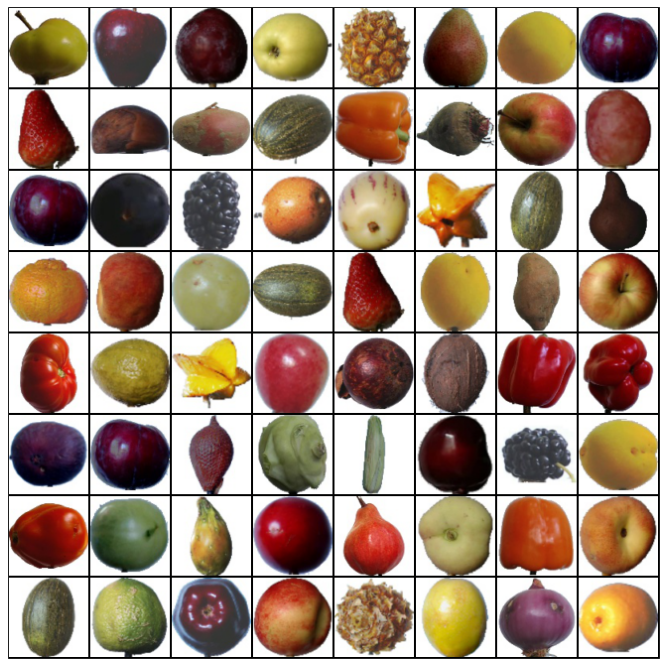

In [28]:
show_batch(val_dl)

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [31]:
class FruitsResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 131)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [33]:
model = FruitsResnet()
model

FruitsResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
model = to_device(FruitsResnet(), device)

In [39]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.891702175140381, 'val_acc': 0.0037146226968616247}]

In [40]:
epochs = 3
lr = 1e-4
opt_func = torch.optim.Adam

In [41]:
model.freeze()

In [42]:
history += fit(epochs,lr , model, train_dl, val_dl,opt_func)

Epoch [0], train_loss: 4.0165, val_loss: 3.9094, val_acc: 0.9665
Epoch [1], train_loss: 3.9012, val_loss: 3.9038, val_acc: 0.9658
Epoch [2], train_loss: 3.8975, val_loss: 3.9016, val_acc: 0.9713


In [46]:
epochs = 5
lr = 1e-6
opt_func = torch.optim.Adam

In [47]:
model.unfreeze()

In [48]:
history += fit(epochs,lr , model, train_dl, val_dl,opt_func)

Epoch [0], train_loss: 3.8926, val_loss: 3.8959, val_acc: 0.9838
Epoch [1], train_loss: 3.8920, val_loss: 3.8962, val_acc: 0.9840
Epoch [2], train_loss: 3.8916, val_loss: 3.8943, val_acc: 0.9853
Epoch [3], train_loss: 3.8915, val_loss: 3.8946, val_acc: 0.9866
Epoch [4], train_loss: 3.8912, val_loss: 3.8950, val_acc: 0.9847


In [49]:
epochs = 4
lr = 1e-6
opt_func = torch.optim.Adam

In [50]:
history += fit(epochs,lr , model, train_dl, val_dl,opt_func)

Epoch [0], train_loss: 3.8910, val_loss: 3.8956, val_acc: 0.9859
Epoch [1], train_loss: 3.8908, val_loss: 3.8944, val_acc: 0.9862
Epoch [2], train_loss: 3.8906, val_loss: 3.8945, val_acc: 0.9866
Epoch [3], train_loss: 3.8905, val_loss: 3.8945, val_acc: 0.9865


In [53]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    sns.set(rc={'figure.figsize':(6,6)})
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

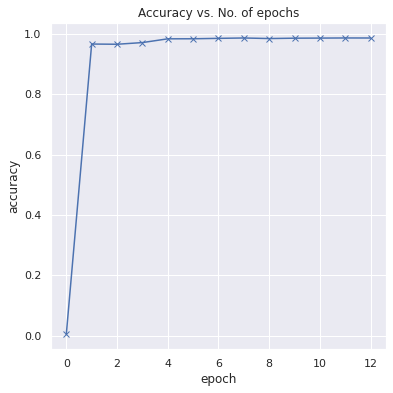

In [54]:
plot_accuracies(history)

In [71]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    sns.set(rc={'figure.figsize':(6,6)})
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

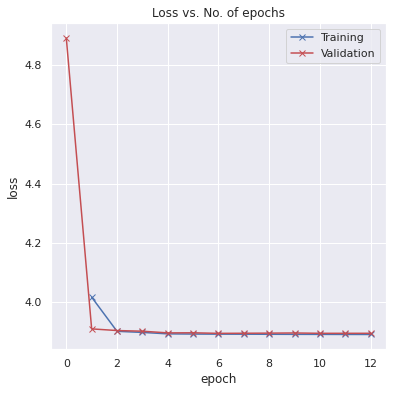

In [72]:
plot_losses(history)

# TESTING THE MODEL ON TESTSET

In [57]:
test_dl = DataLoader(
        test_ds, batch_size=32, shuffle=False,
        num_workers=4, pin_memory=True)

In [58]:
test_dl = DeviceDataLoader(test_dl, device)

**Predicting single images on testset to see accuracy**

In [76]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Apple Braeburn , Predicted: Apple Braeburn


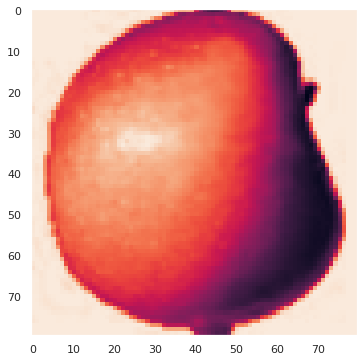

In [73]:
img, label =test_ds[131]
plt.rcParams["axes.grid"] = False
plt.imshow(img[0], cmap=None)
print('Label:',  test_ds.classes[label], ', Predicted:',  test_ds.classes[predict_image(img, model)])

Label: Lemon , Predicted: Lemon


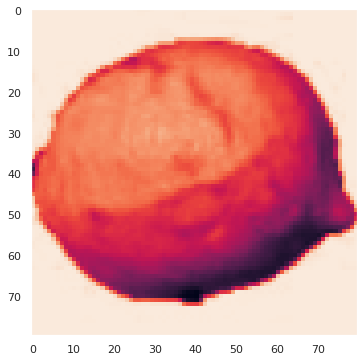

In [75]:
img, label =test_ds[10096]
plt.rcParams["axes.grid"] = False
plt.imshow(img[0], cmap=None)
print('Label:',  test_ds.classes[label], ', Predicted:',  test_ds.classes[predict_image(img, model)])

Label: Strawberry Wedge , Predicted: Strawberry Wedge


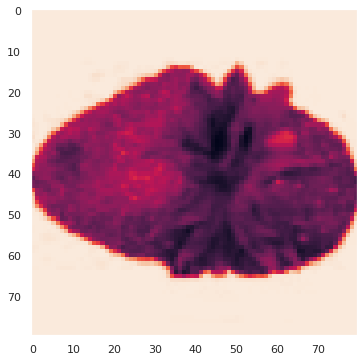

In [79]:
img, label =test_ds[20096]
plt.rcParams["axes.grid"] = False
plt.imshow(img[0], cmap=None)
print('Label:',  test_ds.classes[label], ', Predicted:',  test_ds.classes[predict_image(img, model)])

In [77]:
evaluate(model, test_dl)

{'val_loss': 3.90152907371521, 'val_acc': 0.972540557384491}

In [80]:
project_name = 'jovian-course-Fruit-detection-model'

In [81]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/prafulthangappa44/jovian-course-Fruit-detection-model


<IPython.core.display.Javascript object>